In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import glob
import time

import cv2
from skimage.feature import hog
from skimage.util.shape import view_as_windows

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

%matplotlib inline

# get test image file names
test_images = glob.glob('test_images/test*.jpg')
test_images = sorted(test_images)
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [2]:
#get vehicles image file names
vehicles1 = glob.glob('vehicles/GTI_Far/image*.png')
vehicles2 = glob.glob('vehicles/GTI_Left/image*.png')
vehicles3 = glob.glob('vehicles/GTI_MiddleClose/image*.png')
vehicles4 = glob.glob('vehicles/GTI_Right/image*.png')
vehicles5 = glob.glob('vehicles/KITTI_extracted/*.png')
vehicles = vehicles1 + vehicles2 + vehicles3 + vehicles4 + vehicles5
vehicles = sorted(vehicles)
vehicles

['vehicles/GTI_Far/image0000.png',
 'vehicles/GTI_Far/image0001.png',
 'vehicles/GTI_Far/image0002.png',
 'vehicles/GTI_Far/image0003.png',
 'vehicles/GTI_Far/image0004.png',
 'vehicles/GTI_Far/image0005.png',
 'vehicles/GTI_Far/image0006.png',
 'vehicles/GTI_Far/image0007.png',
 'vehicles/GTI_Far/image0008.png',
 'vehicles/GTI_Far/image0009.png',
 'vehicles/GTI_Far/image0010.png',
 'vehicles/GTI_Far/image0014.png',
 'vehicles/GTI_Far/image0015.png',
 'vehicles/GTI_Far/image0016.png',
 'vehicles/GTI_Far/image0018.png',
 'vehicles/GTI_Far/image0019.png',
 'vehicles/GTI_Far/image0021.png',
 'vehicles/GTI_Far/image0022.png',
 'vehicles/GTI_Far/image0023.png',
 'vehicles/GTI_Far/image0024.png',
 'vehicles/GTI_Far/image0027.png',
 'vehicles/GTI_Far/image0029.png',
 'vehicles/GTI_Far/image0030.png',
 'vehicles/GTI_Far/image0033.png',
 'vehicles/GTI_Far/image0036.png',
 'vehicles/GTI_Far/image0037.png',
 'vehicles/GTI_Far/image0039.png',
 'vehicles/GTI_Far/image0040.png',
 'vehicles/GTI_Far/i

In [3]:
#get non vehicles image file names
non_vehicles1 = glob.glob('non-vehicles/GTI/image*.png')
non_vehicles2 = glob.glob('non-vehicles/Extras/extra*.png')
non_vehicles = non_vehicles1 + non_vehicles2
non_vehicles = sorted(non_vehicles)
non_vehicles

['non-vehicles/Extras/extra1.png',
 'non-vehicles/Extras/extra10.png',
 'non-vehicles/Extras/extra100.png',
 'non-vehicles/Extras/extra1000.png',
 'non-vehicles/Extras/extra1001.png',
 'non-vehicles/Extras/extra1002.png',
 'non-vehicles/Extras/extra1003.png',
 'non-vehicles/Extras/extra1004.png',
 'non-vehicles/Extras/extra1005.png',
 'non-vehicles/Extras/extra1006.png',
 'non-vehicles/Extras/extra1007.png',
 'non-vehicles/Extras/extra1008.png',
 'non-vehicles/Extras/extra1009.png',
 'non-vehicles/Extras/extra101.png',
 'non-vehicles/Extras/extra1010.png',
 'non-vehicles/Extras/extra1011.png',
 'non-vehicles/Extras/extra1012.png',
 'non-vehicles/Extras/extra1013.png',
 'non-vehicles/Extras/extra1014.png',
 'non-vehicles/Extras/extra1015.png',
 'non-vehicles/Extras/extra102.png',
 'non-vehicles/Extras/extra103.png',
 'non-vehicles/Extras/extra1032.png',
 'non-vehicles/Extras/extra1033.png',
 'non-vehicles/Extras/extra1034.png',
 'non-vehicles/Extras/extra1035.png',
 'non-vehicles/Extras

In [4]:
print('vehicles:', len(vehicles), 'non vehicles:', len(non_vehicles))

vehicles: 8792 non vehicles: 8968


In [5]:
#load images
image_shape = (64,64,3)
vehicles_imgs = np.zeros((len(vehicles),)+image_shape)
non_vehicles_imgs = np.zeros((len(non_vehicles),)+image_shape)

for i, fname in enumerate(vehicles):
    vehicles_imgs[i] = mpimg.imread(fname)
    
for i, fname in enumerate(non_vehicles):
    non_vehicles_imgs[i] = mpimg.imread(fname)
    
print(vehicles_imgs.shape, non_vehicles_imgs.shape)

(8792, 64, 64, 3) (8968, 64, 64, 3)


In [6]:
#check value range(0~1 or 0~255)
vehicles_imgs[0]

array([[[0.61176473, 0.65882355, 0.63921571],
        [0.61176473, 0.65882355, 0.63921571],
        [0.61176473, 0.65490198, 0.63529414],
        ...,
        [0.39215687, 0.43921569, 0.35294119],
        [0.40000001, 0.44313726, 0.35686275],
        [0.40392157, 0.44313726, 0.35686275]],

       [[0.61176473, 0.65882355, 0.63921571],
        [0.61176473, 0.65882355, 0.63921571],
        [0.61176473, 0.65490198, 0.63529414],
        ...,
        [0.39215687, 0.43921569, 0.35294119],
        [0.40000001, 0.44313726, 0.35686275],
        [0.40392157, 0.44313726, 0.35686275]],

       [[0.61176473, 0.65490198, 0.63137257],
        [0.61176473, 0.65490198, 0.63137257],
        [0.61176473, 0.65098041, 0.627451  ],
        ...,
        [0.39215687, 0.44313726, 0.35294119],
        [0.40000001, 0.44705883, 0.36078432],
        [0.40392157, 0.44705883, 0.36078432]],

       ...,

       [[0.48235294, 0.50196081, 0.4509804 ],
        [0.48235294, 0.50196081, 0.4509804 ],
        [0.48235294, 0

In [12]:
def convert_color(img, conv='RGB2YCrCb', png=True):
    if png==True:
        image = np.copy(img) * 255
        image = image.astype(np.uint8)
    else:
        image = np.copy(img)
    
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    else:
        return image
        

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, conv='RGB2YCrCb', png=True, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for i in range(len(imgs)):
        feature_image = convert_color(imgs[i],conv=conv,png=png)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = [get_hog_features(feature_image[:,:,channel], 
                                             orient, pix_per_cell, cell_per_block, 
                                             vis=False, feature_vec=True)
                           for channel in range(feature_image.shape[2])]
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
    # Return list of feature vectors
    return features

#parameters
conv_cspace = 'RGB2YCrCb'
# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# RGB:93.3, HSV:95.4, LUV:95.0 , HLS:94.8, YUV:96.2, YCrCb:96.2

orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial = 16
spatial_size = (spatial, spatial)
hist_bins = 64

t=time.time()
vehicles_features = extract_features(vehicles_imgs, conv=conv_cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256))
non_vehicles_features = extract_features(non_vehicles_imgs, conv=conv_cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicles_features, non_vehicles_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(non_vehicles_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

83.66 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8016
(15984, 8016) (1776, 8016) (15984,) (1776,)


In [13]:
linear_svc = LinearSVC()
t=time.time()
linear_svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(linear_svc.score(X_test, y_test), 4))

20.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


In [14]:
del X_train, X_test, y_train, y_test, X, y, vehicles_features, non_vehicles_features


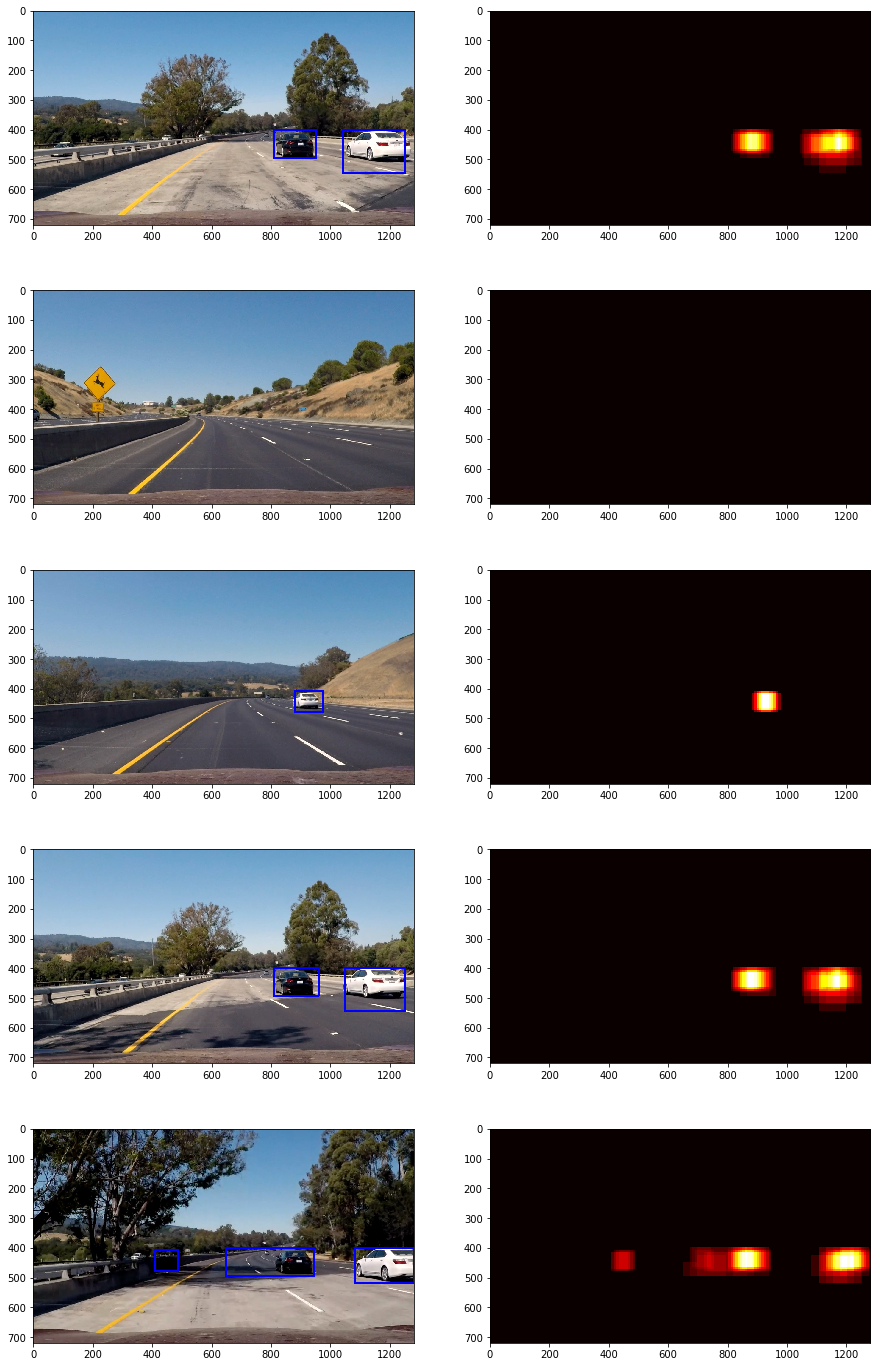

In [15]:

def find_bbox(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, cells_per_step):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Compute individual channel HOG features for the entire image
    hog_feat_all = [get_hog_features(ctrans_tosearch[:,:,channel], 
                                             orient, pix_per_cell, cell_per_block, 
                                             vis=False, feature_vec=False)
                           for channel in range(ctrans_tosearch.shape[2])]
    
    bbox = []
    hog_feats = []
    for channel in range(ctrans_tosearch.shape[2]):
        hog_feat = get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                             vis=False, feature_vec=False)
        hog_window_shape = (nblocks_per_window, nblocks_per_window, cell_per_block,cell_per_block,orient)
        hog_windows = view_as_windows(hog_feat , hog_window_shape, cells_per_step)
        hog_windows = hog_windows.reshape(-1, nblocks_per_window, nblocks_per_window, 
                                          cell_per_block, cell_per_block, orient)
        hog_feats.append(hog_windows.reshape(hog_windows.shape[0],-1)) 
        
    img_window_shape = (window, window, 3)
    img_windows = view_as_windows(ctrans_tosearch , img_window_shape,  cells_per_step * pix_per_cell)
    img_windows_ny = img_windows.shape[0]
    img_windows_nx = img_windows.shape[1]
    img_windows = img_windows.reshape(-1, window, window, 3)
    
    spatial_feats = np.zeros((img_windows.shape[0],spatial*spatial*3))
    hist_feats = np.zeros((img_windows.shape[0],hist_bins*3))
    
    for i in range(len(img_windows)):
        spatial_feats[i] = bin_spatial(img_windows[i], size=spatial_size)
        hist_feats[i] = color_hist(img_windows[i], nbins=hist_bins)
    all_feats = np.concatenate((hog_feats[0],hog_feats[1],hog_feats[2], spatial_feats, hist_feats),axis=-1)
    test_feats = X_scaler.transform(all_feats)
    test_prediction = svc.predict(test_feats)
    for i in range(len(test_prediction)):
        if test_prediction[i]== 1:
            xbox_left = np.int((i%img_windows_nx)*pix_per_cell*cells_per_step*scale)
            ytop_draw = np.int((i//img_windows_nx)*pix_per_cell*cells_per_step*scale)
            win_draw = np.int(window*scale)
            box_top_left = (xbox_left, ytop_draw+ystart)
            box_bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
            bbox.append((box_top_left,box_bottom_right))
            
    return bbox
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

ystart = [400,400,400]
ystop = [650,550,480]
scale = [2.3,1.5,1.0]
cells_per_step = [3,2,1]

disp_row = 6
disp_col = 2
fig = plt.figure(figsize=(15,30))
for i,fname in enumerate(test_images[:5]):
    bboxes = []
    img = mpimg.imread(fname)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for j in range(len(scale)):
        bbox = find_bbox(img, ystart[j], ystop[j], scale[j], linear_svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins,cells_per_step[j])
        bboxes += bbox
        
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heatmap_threshold = 1
    heat = apply_threshold(heat,heatmap_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    fig.add_subplot(disp_row,disp_col,2*i+1)
    plt.imshow(draw_img)
    fig.add_subplot(disp_row,disp_col,2*i+2)
    plt.imshow(heatmap, cmap='hot')

In [16]:
class LaneCarDetection():
    def __init__(self, svc, X_scaler, png=True, image_shape=(720, 1280, 3)):
        self.image_shape = image_shape
        self.svc = svc
        self.X_scaler = X_scaler
        self.png = png
        
        #color space
        self.conv_cspace = 'RGB2YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        
        #HOG
        self.orient = 12
        self.pix_per_cell = 8
        self.cell_per_block = 2
        
        #HOG sampling
        self.window = 64
        self.cells_per_step = [3,2,1]  # Instead of overlap, define how many cells to step
        self.ystart = [400,400,400] #region of interest y start
        self.ystop = [650,550,480] #region of interest y stop
        self.scale = [2.3,1.5,1.0] #window scale
        
        #bins
        self.spatial = 16
        self.spatial_size = (spatial, spatial)
        self.hist_bins = 64
        self.hist_bins_range = (0, 256)
        
        #heatmap
        self.heatmap_threshold = 2
        self.heatmap_memory_threshold = 4
        
        #memory
        self.mem_max_length = 40
        self.mem_length = 0
        self.mem_start = 0
        self.heatmap_memory = np.zeros((self.mem_max_length,)+self.image_shape[:2])
        
        #filter
        self.bbox_filter_size = 30
        
        
        #lane finding
        #max len of buffer
        self.maxlen = 10
        #starting idx for fit and curvature
        self.start_fit = 0
        #starting idx for distance
        self.start_dis = 0
        #current length
        self.length_fit = 0
        #current length
        self.length_dis = 0
        
        # polynomial coefficients of the last n fits of the line
        self.recent_fit = np.zeros((self.maxlen,3,2))
        #polynomial coefficients averaged over the last n iterations
        self.ave_left_fit = None
        self.ave_right_fit = None
        
        #recent curvature (left,right)
        self.recent_curvature = np.zeros((self.maxlen,2))
        #radius of curvature of the line in meters
        self.ave_curvature_meter = None 
        
        #recent distance
        self.recent_distance = np.zeros(self.maxlen)
        #distance in meters of vehicle from the line center
        self.ave_distance = None 
        
        self.curvature_threshold = 1.
        self.fit_threshold = 8.
        self.distance_threshold = 2.
        
        #all parameters
        self.img_size = (1280, 720)
        self.coeff = np.load('camera_calibration_coeff.npz')
        self.mtx = self.coeff['mtx']
        self.dist = self.coeff['dist']
        self.transform_src = np.float32([[701,460],
                                  [1070,700],
                                  [230,700],
                                  [581,460]])
        self.transform_dst = np.float32([[1030,10],
                                  [1030,700],
                                  [250,700],
                                  [250,10]])
        self.M = cv2.getPerspectiveTransform(self.transform_src, self.transform_dst)
        self.Minv = cv2.getPerspectiveTransform(self.transform_dst, self.transform_src)
        #for fits
        self.ploty = np.linspace(0, self.img_size[1]-1, self.img_size[1]) #0~719
        self.fitx_pixel = None
        
    def convert_color(self, img, conv='RGB2YCrCb', png=True):
        if png==True:
            image = np.copy(img) * 255
            image = image.astype(np.uint8)
        else:
            image = np.copy(img)

        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif conv == 'BGR2YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        elif conv == 'RGB2LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        else:
            return image


    def get_hog_features(self, img, vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=self.orient, 
                                      pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block),
                                      block_norm= 'L2-Hys',
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                           cells_per_block=(self.cell_per_block, self.cell_per_block),
                           block_norm= 'L2-Hys',
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features

    def bin_spatial(self, img):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, self.spatial_size).ravel() 
        # Return the feature vector
        return features

    def color_hist(self, img):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.hist_bins, range=self.hist_bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.hist_bins, range=self.hist_bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.hist_bins, range=self.hist_bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def find_bbox(self, img, ystart, ystop, scale, cells_per_step):
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = self.convert_color(img_tosearch, conv=self.conv_cspace, png=self.png)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        nblocks_per_window = (self.window // self.pix_per_cell) - self.cell_per_block + 1
        
        bbox = []
        hog_feats = []
        for channel in range(ctrans_tosearch.shape[2]):
            hog_feat = self.get_hog_features(ctrans_tosearch[:,:,channel], vis=False, feature_vec=False)
            hog_window_shape = (nblocks_per_window, nblocks_per_window, 
                                self.cell_per_block,self.cell_per_block,self.orient)
            hog_windows = view_as_windows(hog_feat, hog_window_shape, cells_per_step)
            hog_windows = hog_windows.reshape(-1, nblocks_per_window, nblocks_per_window, 
                                              self.cell_per_block, self.cell_per_block, self.orient)
            hog_feats.append(hog_windows.reshape(hog_windows.shape[0],-1)) 

        img_window_shape = (self.window, self.window, 3)
        img_windows = view_as_windows(ctrans_tosearch , img_window_shape,  cells_per_step * self.pix_per_cell)
        img_windows_ny = img_windows.shape[0]
        img_windows_nx = img_windows.shape[1]
        img_windows = img_windows.reshape(-1, self.window, self.window, 3)

        spatial_feats = np.zeros((img_windows.shape[0],self.spatial*self.spatial*3))
        hist_feats = np.zeros((img_windows.shape[0],self.hist_bins*3))

        for i in range(len(img_windows)):
            spatial_feats[i] = self.bin_spatial(img_windows[i])
            hist_feats[i] = self.color_hist(img_windows[i])
        all_feats = np.concatenate((hog_feats[0],hog_feats[1],hog_feats[2], spatial_feats, hist_feats),axis=-1)
        test_feats = self.X_scaler.transform(all_feats)
        test_prediction = self.svc.predict(test_feats)
        for i in range(len(test_prediction)):
            if test_prediction[i]== 1:
                xbox_left = np.int((i%img_windows_nx)*self.pix_per_cell*cells_per_step*scale)
                ytop_draw = np.int((i//img_windows_nx)*self.pix_per_cell*cells_per_step*scale)
                win_draw = np.int(self.window*scale)
                box_top_left = (xbox_left, ytop_draw+ystart)
                box_bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                bbox.append((box_top_left,box_bottom_right))
                
        return bbox

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def add_heat_memory(self, heatmap):
        if self.mem_length == self.mem_max_length:
            self.mem_start = (self.mem_start + 1) % self.mem_max_length
        else:
            self.mem_length += 1
        idx = (self.mem_start + self.mem_length - 1) % self.mem_max_length
        self.heatmap_memory[idx] = heatmap  
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            #filter very small boxes
            min_x = np.min(nonzerox)
            min_y = np.min(nonzeroy)
            max_x = np.max(nonzerox)
            max_y = np.max(nonzeroy)
            if (max_x - min_x) > self.bbox_filter_size and (max_y - min_y) > self.bbox_filter_size:
                bbox = ((min_x, min_y), (max_x, max_y))
                # Draw the box on the image
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    def add_fit_curvature(self, left_fit, right_fit, left_curvature, right_curvature):
        #add to memory (discard large noises)
        if self.length_fit == self.maxlen:
            self.start_fit = (self.start_fit + 1) % self.maxlen
        else:
            self.length_fit += 1
        idx = (self.start_fit + self.length_fit - 1) % self.maxlen
        last_idx = (idx-1) % self.maxlen
        
        #poly fit
        if self.ave_left_fit is not None:
            if abs(self.ave_left_fit[0]-left_fit[0])<self.fit_threshold*abs(self.ave_left_fit[0]):
                self.recent_fit[idx,:,0] = left_fit
            else:
                self.recent_fit[idx,:,0] = self.recent_fit[last_idx,:,0] 
        else:
            self.recent_fit[0,:,0] = left_fit
            
        if self.ave_right_fit is not None:
            if abs(self.ave_right_fit[0]-right_fit[0])<self.fit_threshold*abs(self.ave_right_fit[0]):
                self.recent_fit[idx,:,1] = right_fit
            else:
                self.recent_fit[idx,:,1] = self.recent_fit[last_idx,:,1] 
        else:
            self.recent_fit[0,:,1] = right_fit
        self.ave_left_fit = np.sum(self.recent_fit[:,:,0],axis=0)/self.length_fit
        self.ave_right_fit = np.sum(self.recent_fit[:,:,1],axis=0)/self.length_fit
        
        #curvature
        if self.ave_curvature_meter is not None:
            if abs(self.ave_curvature_meter-left_curvature)<self.curvature_threshold*abs(self.ave_curvature_meter):
                self.recent_curvature[idx,0] = left_curvature
            else:
                self.recent_curvature[idx,0] = self.recent_curvature[last_idx,0] 
                
            if abs(self.ave_curvature_meter-right_curvature)<self.curvature_threshold*abs(self.ave_curvature_meter):
                self.recent_curvature[idx,1] = right_curvature
            else:
                self.recent_curvature[idx,1] = self.recent_curvature[last_idx,1] 
        else:
            self.recent_curvature[0,0] = left_curvature
            self.recent_curvature[0,1] = right_curvature
        self.ave_curvature_meter = 0.5 * np.sum(self.recent_curvature)/self.length_fit
    
    def add_distance(self, distance):
        if self.length_dis == self.maxlen:
            self.start_dis = (self.start_dis + 1) % self.maxlen
        else:
            self.length_dis += 1
        idx = (self.start_dis + self.length_dis - 1) % self.maxlen
        last_idx = (idx-1) % self.maxlen
        #distance
        if self.ave_distance is not None:
            if abs(self.ave_distance-distance)<self.distance_threshold*abs(self.ave_distance):
                self.recent_distance[idx] = distance
            else:
                self.recent_distance[idx] = self.recent_distance[last_idx] 
        else:
            self.recent_distance[0] = distance
        self.ave_distance = np.sum(self.recent_distance)/self.length_dis
        
    def get_binary_image(self, img):
        """image to binary image"""
        r_channel = img[:,:,0]

        #HLS
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]

        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sx_thresh = (20, 100)
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        #s threshold
        s_thresh = (170, 255)
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        #r threshold
        r_thresh = (230, 255)
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

        #combine
        combined_binary = np.zeros_like(s_binary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        combined_binary[(r_binary == 1) | (combined_binary == 1)] = 1
        return combined_binary

    def get_polyfit(self, binary_warped):
        """get poly fits and colored lane img"""
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        colored_lane_out_img = np.zeros_like(out_img)
        # Find the peak of the left and right 
        left_end = 400
        right_start = 880
        leftx_base = np.argmax(histogram[:left_end])
        rightx_base = np.argmax(histogram[right_start:]) + right_start

        # Choose the number of sliding windows
        nwindows = 8
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 120
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        #color lanes
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        colored_lane_out_img[lefty, leftx] = [255, 0, 0]
        colored_lane_out_img[righty, rightx] = [0, 0, 255]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the curvature(meter)
        y_eval = binary_warped.shape[1]-1
        left_curverad_meter = (((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) 
                               / np.absolute(2*left_fit_cr[0]))
        right_curverad_meter = (((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) 
                                / np.absolute(2*right_fit_cr[0]))
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #add
        self.add_fit_curvature(left_fit, right_fit, left_curverad_meter, right_curverad_meter)
        
        #get fitted x
        left_fitx = self.ave_left_fit[0]*self.ploty**2 + self.ave_left_fit[1]*self.ploty + self.ave_left_fit[2]
        right_fitx = self.ave_right_fit[0]*self.ploty**2 + self.ave_right_fit[1]*self.ploty + self.ave_right_fit[2]
        self.fitx_pixel = [left_fitx,right_fitx]
        return out_img, colored_lane_out_img

    def color_road(self, colored_lane):
        """get colored road"""
        colored_road = np.copy(colored_lane)
        left_fitx = self.fitx_pixel[0]
        right_fitx = self.fitx_pixel[1]

        left_coord = np.stack((left_fitx,self.ploty),axis=1)
        right_coord = np.flipud(np.stack((right_fitx,self.ploty),axis=1))
        coords = np.concatenate((left_coord,right_coord),axis=0).reshape((-1,1,2))
        pts = coords.astype(int)
        cv2.fillPoly(colored_road, [pts], [0,255,0])
        return colored_road

    def find_center(self, inv_warped):
        """from inverse warped colored lanes find center"""
        pixel_meter_x = 3.7/900.
        inv_warped_g = inv_warped[:,:,1]
        nonzero_idx = np.array(np.nonzero(inv_warped_g[-1,:])).reshape(-1)
        center = 0.5 * (nonzero_idx[0]+nonzero_idx[-1])
        midpoint = 0.5 * inv_warped_g.shape[1]
        distance_meter = (midpoint-center) * pixel_meter_x
        return distance_meter
    
    def find_lane_lines_and_cars(self, img):
        #undistort
        undistorted_img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        #to binary
        binary_img = self.get_binary_image(undistorted_img)
        #warp
        warped = cv2.warpPerspective(binary_img, self.M, self.img_size, flags=cv2.INTER_LINEAR)
        #fit and color lanes
        out_img, colored_lane_out_img = self.get_polyfit(warped)
        #color road
        colored_road_img = self.color_road(colored_lane_out_img)
        #inv warp
        inv_warped = cv2.warpPerspective(colored_road_img, self.Minv, self.img_size, flags=cv2.INTER_LINEAR)
        #find distance from midpoint
        distance = self.find_center(inv_warped)
        distance_str = '{:.3f}'.format(abs(distance))
        if distance>=0.:
            left_right='right'
        else:
            left_right='left'

        weighted_img = cv2.addWeighted(undistorted_img, 1.0, inv_warped, 0.4, 0.)

        cv2.putText(weighted_img,'Radius of Curvature = '+str(round(self.ave_curvature_meter))+'(m)',
                    (50,100),cv2.FONT_HERSHEY_SIMPLEX,2,[255,255,255], 4)
        cv2.putText(weighted_img,'Vehicle is '+distance_str+'m '+left_right+' of the center',
                    (50,200),cv2.FONT_HERSHEY_SIMPLEX,2,[255,255,255], 4)
        
        bboxes = []
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        for j in range(len(self.scale)):
            bbox = self.find_bbox(undistorted_img, self.ystart[j], self.ystop[j], self.scale[j], self.cells_per_step[j])
            bboxes += bbox

        # Add heat to each box in box list
        heat = self.add_heat(heat,bboxes)
        heat = self.apply_threshold(heat,self.heatmap_threshold)
        self.add_heat_memory(heat)
        
        #heatmap memory threshold
        heat = np.mean(self.heatmap_memory,axis=0)
        heat = self.apply_threshold(heat,self.heatmap_memory_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat.astype(int), 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(np.copy(weighted_img), labels)
        
        return draw_img

In [17]:
from moviepy.editor import VideoFileClip

lane_car_detection = LaneCarDetection(linear_svc,X_scaler,png=False)

project_output = 'output_videos/project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(lane_car_detection.find_lane_lines_and_cars) 

%time out_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [13:40<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 44min 50s, sys: 1min 49s, total: 46min 39s
Wall time: 13min 41s
